# New LangGraph 8/19
- db search를 3단계로 나눠서 검색
- LangGraph 구현을 위한 코드
 - 변경점
    - 그래프를 고도화시켜서 한번에 db_search를 수행하는 것이 아닌 분기를 두고 수행하도록 변경
    - keyword 추출에 gpt-4o-mini
    - scheduler 생성에 gpt-4-turbo

## Import Packages

In [1]:
from typing import TypedDict, Annotated, Optional, List
import operator
import ast
import pandas as pd
import os
import json
from dotenv import load_dotenv

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough, RunnableMap
from langchain.memory import ConversationSummaryBufferMemory
from IPython.display import Image, display
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

## Define State

In [2]:
# 랭그래프
class LangState(TypedDict):
    model: Optional[ChatOpenAI] # Model (GPT4 turbo, o-mini, Naver(?))
    question: Optional[str]  # 사용자의 입력질문
    keywords: Optional[dict] # 입력질문으로 뽑아낸 키워드
    foods_context: Optional[dict]#Annotated[str, operator.add] # 뽑힌 여행지들
    playing_context: Optional[str]#Annotated[str, operator.add] # 뽑힌 여행지들
    hotel_context: Optional[str]#Annotated[str, operator.add] # 뽑힌 여행지들
    scheduler: Optional[dict] # 최종 여행지
    explain : Optional[str]#Annotated[str, operator.add]
    second_sentence: str # 검증
    # sql_query: Annotated[str, operator.add] # 키워드를 기반으로 db 조회하는 쿼리
    api_key: str # Not Used for now

In [2]:
class LangState(TypedDict):
    model: Optional[ChatOpenAI]
    question: Optional[str]
    keywords: Annotated[Optional[dict], operator.add]
    foods_context: Annotated[Optional[dict], operator.add]
    playing_context: Annotated[Optional[dict], operator.add]
    hotel_context: Annotated[Optional[dict], operator.add]
    scheduler: Annotated[Optional[dict], operator.add]
    explain: Optional[str]
    second_sentence: str
    api_key: str

## Define Function

In [3]:
# 실제로는 sql을 조회하게 될 함수
def get_db():
    ''''''
    return db

In [4]:
# 분기 체크 코드
def is_do_again(state: LangState) -> LangState:
    # 끝났는지 검사
    return state['second_sentence']

In [5]:
# 사용자 DB를 조회해서 연령대를 결정하는 함수
def get_age_group(age):
    if age < 20:
        return '10대'
    elif age < 30:
        return '20대'
    elif age < 40:
        return '30대'
    elif age < 50:
        return '40대'
    elif age < 60:
        return '50대'
    else:
        return '60+대'

## Define Nodes

In [6]:
def input_text(state: LangState) -> LangState:

    question = input("안녕하세요! 어떤 여행을 떠나고 싶으신가요??\t")
    model = ChatOpenAI(temperature=0.3, model="gpt-4o-mini")
    return LangState(question=question, model=model)

def find_keywords(state: LangState) -> LangState:
    
    # 질문과 키워드 기초 상태 받아오기
    question = state['question']
    keywords = {
        'days': None,
        'transport': None,
        'companion': None,
        'theme': None,
        'food': None
    }

    while any(value is None for value in keywords.values()):  # 모든 키워드가 채워질 때까지 반복
        # GPT에게 현재 입력된 정보로부터 키워드 추출 요청
        prompt = ChatPromptTemplate.from_messages([
            ("system", """
        You need to extract the most relevant information from the user's sentence in the context of a trip. 
        The user may provide information about the following categories:
        1. How many days they want to travel (days).
        2. What transportation they have (transport).
        3. Who they are traveling with (companion).
        4. What theme they prefer for the trip (theme).
        5. What type of food they prefer (food).

        Basically, you find keywords from user's input, but you can also recommend keyword as possible as you can.
        For example
        - if the input is '쉬러 가고 싶어' means '휴식' so you can recommend '바다' or '자연' or '공원'
        - if the input is '라면먹고 싶어' means wanna eat '라면' so you can recommend '한식' or '일식'
        - if the input is '사람들을 만나러 가고싶어' means wanna hang with people, so you can recommend '도시' or '체험' or '쇼핑'
        - if the input is '아무거나' or '상관없어' or '아무데나' means everywhere and everything, so you can recommend randomly from format.
        - if the input is '나머지는 추천해줘' or '나머지는 알아서 해줘' means recommend the rest of categories, so you can recommend from format for the rest of categories.
        
        Following Rules:
        - if you are short of information from user's sentence, but user just want recommend of rest, then you can recommend from format.
        - Recommending is your option, but you just return one keyword at one category.

        days
        - just return Number of days. liks 'N'. just integer.

        transport
        - if user have a car, or rent a car means '자차', but if user use taxi, bus, airplane, or other things not a car, then '대중교통'

        response
        - When the number of categories provided from the user's input is insufficient, a message providing additional information may be transmitted to the user as response.
        - Your reaction is as natural like to respond appropriately to the other person's sentence as you're having a real conversation, and at the same time, you ask questions to receive categories that you lack.
        - if you get all categories, then just return 'End' at response.

        user input: "{question}, {keywords}"

        Return the information in the following format:
        {{
            'days': 'Number of days' or None,
            'transport': '자차/대중교통' or None,
            'companion': '가족/부모/친구/연인/혼자' or None,
            'theme': '자연/걷기/쇼핑/공원/이색여행/문화/체험/역사/산/바다/도시' or None,
            'food': '한식/양식/중식/일식/아시아' or None,
            'response': 'response'
        }}
        """),
        ("human","{question}, {keywords}")
        ])

        chain = prompt | state['model']
        response = chain.invoke({"question": question, "keywords": keywords})
        extracted_keywords = ast.literal_eval(response.content)

        # 이미 대답된 정보를 저장
        for key, value in extracted_keywords.items():
            if key in keywords and value is not None and key != 'response':
                if keywords[key] is None: keywords[key] = value
        
        # 모든 키워드가 채워졌는지 확인하여 루프 종료
        if all(value is not None for value in keywords.values()):
            break

        # Check if the response suggests asking for more relevant travel information
        if 'response' in extracted_keywords and extracted_keywords['response'] != 'End':
            print(extracted_keywords['response'])
            question = input(": ").strip()
            continue  # Re-run the loop to process the new input
    
    return LangState(keywords=keywords)

def foods_search(state: LangState) -> LangState:

    #data 조회함수 -> hotels.csv 및 user의 나이까지 반환해야함.
    user_age = 29
    data = pd.read_csv('./real_datas/foods.csv')

    keywords = state['keywords']
    k = int(state['keywords']['days'])
    
    def recommend_restaurants(data, condition, user_age, k):
        # 연령대 설정
        if condition['companion'] == '부모':
            user_age_group = '60+대'
        else:
            user_age_group = get_age_group(user_age)
        
        # Companion 및 술집 필터링
        if condition['companion'] in ['가족', '부모']:
            data = data[data['술집여부'] == 0]
        
        # Time-based Filtering
        def filter_by_time(time_slot):
            if time_slot == '아침':
                return data[(data['운영시간0'] == 1) | (data['운영시간1'] == 1) | (data['운영시간2'] == 1)]
            elif time_slot == '점심':
                return data[(data['운영시간2'] == 1) | (data['운영시간3'] == 1)]
            elif time_slot == '저녁':
                return data[(data['운영시간4'] == 1) | (data['운영시간5'] == 1)]
        
        # 가중치 계산
        def calculate_weights(row):
            # Food 가중치
            food_weight = 0.43 if row['카테고리명'] == condition['food'] else 0.28
        
            # 연령대 가중치
            age_score = row[user_age_group]
            
            # 최종 점수 계산
            return food_weight * age_score
        
        # 아침, 점심, 저녁 별로 추천 4k개만큼
        recommendations = {}
        recommended_restaurants = set()
        for time_slot in ['아침', '점심', '저녁']:
            filtered_data = filter_by_time(time_slot).copy()  # 명시적으로 복사본을 생성
            filtered_data['FinalScore'] = filtered_data.apply(calculate_weights, axis=1)
            top_restaurants = filtered_data[~filtered_data['업체명'].isin(recommended_restaurants)] \
                .sort_values(by='FinalScore', ascending=False).head(k*4)
            
            recommendations[time_slot] = list(zip(top_restaurants['업체명'], top_restaurants['위도'], top_restaurants['경도']))
            
            # 이미 추천된 식당을 추적하여 다음 시간대에 제외
            recommended_restaurants.update(top_restaurants['업체명'])
        
        return recommendations

    response = recommend_restaurants(data, keywords, user_age, k)

    return LangState(foods_context=response)

def hotels_search(state: LangState) -> LangState:

    #data 조회함수 -> hotels.csv 및 user의 나이까지 반환해야함.
    user_age = 29
    data = pd.read_csv('./real_datas/hotels.csv')

    keywords = state['keywords']
    k = int(state['keywords']['days'])

    def recommend_accommodation_with_keywords(data, condition, user_age, k):
        # 연령대 설정
        if condition['companion'] == '부모':
            user_age_group = '60+대'
        else:
            user_age_group = get_age_group(user_age)
        
        # 숙박 유형 가중치 설정
        accommodation_weight = {
        '가족': {'호텔': 0.3, '모텔': 0.1, '펜션': 0.6, '게스트하우스': 0},
        '부모': {'호텔': 0.48, '모텔': 0.125, '펜션': 0.395, '게스트하우스': 0},
        '친구': {'호텔': 0.265, '모텔': 0.205, '펜션': 0.26, '게스트하우스': 0.27},
        '연인': {'호텔': 0.27, '모텔': 0.37, '펜션': 0.27, '게스트하우스': 0.09},
        '혼자': {'호텔': 0.263, '모텔': 0.264, '펜션': 0, '게스트하우스': 0.473},
        }
        
        # 필터링
        filtered_data = data.copy()
        
        # 교통수단에 따른 주차 필터링
        if condition['transport'] == '자차':
            filtered_data = filtered_data[filtered_data['주차가능여부'] == 'Y']
        
        # 숙박 유형 점수 계산
        filtered_data['숙박유형점수'] = filtered_data['숙박유형'].apply(lambda x: accommodation_weight[condition['companion']].get(x, 0))
        
        # 연령대 점수 계산
        filtered_data['연령대추천'] = filtered_data[user_age_group]
        
        # 총점 계산
        filtered_data['총점'] = filtered_data['숙박유형점수'] * filtered_data['연령대추천']
        
        # 총점 기준으로 상위 3k개 숙박지 추천
        recommended = filtered_data.sort_values(by='총점', ascending=False).head(k*3)

        # 이름, 위도, 경도 리스트로 반환
        result = list(zip(recommended['이름'], recommended['위도'], recommended['경도']))
        return result
        
    response = recommend_accommodation_with_keywords(data, keywords, user_age, k)

    return LangState(hotel_context=response)

def places_search(state: LangState) -> LangState:
    
    #data 조회함수 -> hotels.csv 및 user의 나이까지 반환해야함.
    user_age = 29
    data = pd.read_csv('./real_datas/places.csv')

    keywords = state['keywords']
    k = int(state['keywords']['days'])

    def recommend_travel_destinations(data, condition, user_age, k):
        # 연령대 설정
        if condition['companion'] == '부모':
            user_age_group = '60+대'
        else:
            user_age_group = get_age_group(user_age)
        
        # Companion 가중치 계산
        data['CompanionWeight'] = data[condition['companion']].apply(lambda x: 0.6 if x == 1 else 0.1)
        
        # Theme 그룹 설정
        theme_groups = {
            '자연': ['산', '바다', '공원', '걷기'],
            '도시': ['쇼핑', '축제', '문화', '기타'],
            '역사': ['역사', '걷기', '문화'],
            '이색여행': ['이색여행', '체험', '공원'],
            '바다': ['바다', '여름'],
            '산': ['산', '걷기', '가을'],
            '문화': ['문화', '축제', '도시'],
            '체험': ['이색여행'],
            '공원': ['공원', '자연'],
            '쇼핑': ['쇼핑', '도시', '축제'],
            '축제': ['축제', '문화', '쇼핑'],
            '걷기': ['이색여행', '산', '공원', '자연', '문화', '역사', '도시'],
            '기타': ['자연', '걷기', '공원', '쇼핑', '이색여행', '문화', '축제', '체험', '역사' ,'산', '바다', '도시']
        }
        
        main_theme = condition['theme']
        related_themes = theme_groups.get(main_theme, [])
        
        # Theme 가중치 계산
        def calculate_theme_weight(row):
            if row[main_theme] == 1:
                return 0.5
            elif any(row[theme] == 1 for theme in related_themes):
                return 0.35
            else:
                return 0.15
        
        data['ThemeWeight'] = data.apply(calculate_theme_weight, axis=1)
        
        # 연령대 점수와 가중치 곱셈
        data['FinalScore'] = data[user_age_group] * data['CompanionWeight'] * data['ThemeWeight']
        
        # 최종 점수 기준 상위 12K개 여행지 추천
        recommended = data.sort_values(by='FinalScore', ascending=False).head(k*12)
        
        # 이름, 위도, 경도 리스트로 반환
        result = list(zip(recommended['이름'], recommended['위도'], recommended['경도']))

        # 이름과 상세설명만 반환
        return result
    
    response = recommend_travel_destinations(data, keywords, user_age, k)

    return LangState(playing_context=response)

def make_schedule(state: LangState) -> LangState:
    model = ChatOpenAI(temperature=0.3, model="gpt-4-turbo")
    prompt = ChatPromptTemplate.from_messages([
    ("system", """
    Your task is to generate a travel itinerary based on the provided data and specific requirements. The output should include both the reasoning behind the itinerary and a daily schedule in JSON format.

    ====
    def generate_itinerary(hotels: list, tourist_spots: list, restaurants: dict, days: int) -> dict:
        Generates a travel itinerary for 'n' days using the provided data. The itinerary should be returned in JSON format and follow these guidelines:

        - Each day's itinerary must include breakfast, lunch, and dinner. Breakfast and lunch should be at different restaurants, while dinner can also be at a restaurant or bar.
        - Each day should include visits to 2 different tourist spots, with a balanced mix of activities (e.g., cultural, natural, historical).
        - A different hotel should be assigned each night, with a maximum of 3 consecutive nights at the same hotel to ensure variety.
        - The itinerary should start at a central location on the first day and end at the same location on the last day (e.g., a train station), but this location is not considered a tourist spot.
        - The itinerary should be unique and slightly different each time it is generated, with random selections of restaurants, tourist spots, and hotels to provide a varied experience.
        - The JSON output should use the day number as the key and include the itinerary for that day as the value.
        - The last day should not include a hotel stay.
        - Provide a detailed explanation of why the itinerary was planned in this way, considering factors such as travel convenience, variety, user preferences, and the optimal use of time.

        Args:
            hotels (list): A list of tuples, where each tuple contains the hotel name, latitude, and longitude (e.g., [(name, latitude, longitude), ...]).
            tourist_spots (list): A list of tuples, where each tuple contains the tourist spot name, latitude, and longitude (e.g., [(name, latitude, longitude), ...]).
            restaurants (dict): A dictionary with keys '아침', '점심', '저녁', and values are lists of tuples containing the restaurant name, latitude, and longitude (e.g., {{'아침': [(name, latitude, longitude), ...], '점심': [...], '저녁': [...]}}).
            days (int): The number of days for the itinerary.

        Returns:
            dict: A dictionary with two keys:
                1. "reasoning": A detailed explanation of the rationale behind the itinerary to korean.
                2. "itinerary": A JSON-formatted dictionary representing the travel itinerary. Each day's itinerary should include locations for breakfast, lunch, dinner, and two tourist spots, along with their respective names and coordinates.

    # Example usage
    result = generate_itinerary(hotels, tourist_spots, restaurants, days)
    return result

    ====
    # Response format
    generate_itinerary({hotels}, {tourist_spots}, {restaurants}, {days})
    ====
    """),
        ("human","{hotels}, {tourist_spots}, {restaurants}, {days}")
    ])

    chain = prompt | model

    # 올바른 변수명을 사용하여 chain을 실행합니다.
    result = chain.invoke({
        "hotels": state['hotel_context'], 
        "tourist_spots": state['playing_context'], 
        "restaurants": state['foods_context'], 
        "days": int(state['keywords']['days'])  # days는 int로 변환
    })

    schedule = result.content

    # 파싱 전, 중간의 ```json```과 ```를 제거합니다.
    json_start = schedule.find('{')
    json_end = schedule.rfind('}')
    json_data_str = schedule[json_start:json_end+1]

    # JSON을 파싱합니다.
    itinerary_data = json.loads(json_data_str)

    # 메시지 추출: JSON 파싱 전의 텍스트를 추출하여 메시지로 저장합니다.
    message_start = schedule.find("Based on the provided data")
    message_end = json_start
    message = schedule[message_start:message_end].strip()

    schedule = json.dumps(itinerary_data['itinerary'], indent=4, ensure_ascii=False)

    return LangState(scheduler=schedule, explain=message, model=model)

def validation(state: LangState) -> LangState:

    model = ChatOpenAI(temperature=0.3, model="gpt-4o-mini")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """
        Your task is to classify the sentence into one of the following categories: ["Other", "Again", "Good"]
        ====
        def classify(sentence: str) -> Literal["Other", "Again", "Good"]:
            Classify the sentence into one of the following categories based on the user's intent:

            - Again: The user wants to start over or re-enter information. Examples include phrases like '처음부터 할래' or '다시 입력하게 해줘'.
            - Other: The user wants to search again or is unsatisfied with the current result. Examples include phrases like '다시 찾아줘' or '여기 별로야'.
            - Good: The user is satisfied or wants to move forward. Examples include phrases like '알겠어' or '좋아'.
            
            Args:
                sentence (str): The sentence that needs to be classified.
            
            Returns:
                Literal["Other", "Again", "Good"]: The classification of the sentence.
        ====
        # Get result
        result = classify_sentence(sentence)
        return result

        ====
        # Response format
        classify("{human}")
        """),
    ("human", "{human}")
    ])
    chain = prompt | model
    answer = chain.invoke({"human": input("어때요?")})
    answer = answer.content

    return LangState(second_sentence=answer, model=model)

## Link Nodes

In [7]:
# get StateGraph & END from langgraph.graph
workflow = StateGraph(LangState)

# Add Nodes
workflow.add_node('input', input_text)
workflow.add_node('keyword', find_keywords)
workflow.add_node('hotels', hotels_search)
workflow.add_node('restaurants', foods_search)
workflow.add_node('playing', places_search)
workflow.add_node('scheduling', make_schedule)
workflow.add_node('validating', validation)

# Link Nodes
workflow.add_edge('input', 'keyword')
workflow.add_edge('keyword', 'hotels')
workflow.add_edge('keyword', 'restaurants')
workflow.add_edge('keyword', 'playing')
workflow.add_edge('hotels', 'scheduling')
workflow.add_edge('restaurants', 'scheduling')
workflow.add_edge('playing', 'scheduling')
workflow.add_edge('scheduling', 'validating')

# Add Conditional Edges
workflow.add_conditional_edges(
    "validating",
    is_do_again,
    {
        "Good" : END,
        "Other": 'scheduling',
        "Again": 'input',
    },
)

# Set Start Point
workflow.set_entry_point('input')

# Set Memory for Log
memory = MemorySaver()

# Compile Graph
app = workflow.compile(checkpointer=memory)

In [8]:
config = RunnableConfig(
    recursion_limit=15, configurable={"thread_id": "TRIPFLOW-RAG"}
)

## Draw Graph

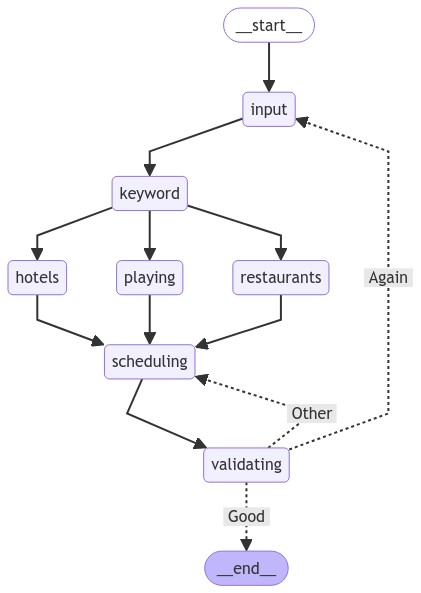

In [9]:
try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )
except Exception as e:
    print(f"Error: {e}")

## Main

In [10]:
def running(LangState, model):
    inputs = LangState(model=model)
    # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
    try:
        for output in app.stream(inputs, config=config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint.pprint(f"Output from node '{key}':")
                pprint.pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint.pprint(value, indent=2, width=80, depth=None)
            # 각 출력 사이에 구분선을 추가합니다.
            pprint.pprint("\n---\n")
    except GraphRecursionError as e:
        pprint.pprint(f"Recursion limit reached: {e}")

In [11]:
# 시작변수들 설정
m = ChatOpenAI(temperature=0.3, model="gpt-4o-mini")

In [12]:
sultsult = running(LangState, m)

"Output from node 'input':"
'---'
{ 'model': ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7f93f05a4040>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7f93f05a70d0>, model_name='gpt-4o-mini', temperature=0.3, openai_api_key=SecretStr('**********'), openai_proxy=''),
  'question': '혼자 사흘여행'}
'\n---\n'
어떤 교통수단을 이용할 계획이신가요? 그리고 여행 테마나 선호하는 음식이 있나요?
음식은 어떤 걸 선호하시나요?
"Output from node 'keyword':"
'---'
{ 'keywords': { 'companion': '혼자',
                'days': '3',
                'food': '한식',
                'theme': '자연',
                'transport': '자차'}}
'\n---\n'
"Output from node 'restaurants':"
'---'
{ 'foods_context': { '아침': [ ( '가얏골감자탕 부산지사점',
                               35.1502764834585,
                               128.834241420557),
                             ('1865이탈리아', 35.1755834176929, 129.125877297588),
                             ('가빈초장', 35.2436967879139, 129.214868447476),
                         

### Remaining Tasks
- MySQL 접속하는 Code단 구현 안되어있음.
- user의 나이를 조회하는 코드도 구현해야함.
- FastAPI 혹은 Flask를 활용해 Spring과 데이터 주고받기 미구현